**извлечение признаков из текста на естественном языке**

word2vec : skip-gram


Евгений Борисов borisov.e@solarl.ru

In [1]:
import sys
import re
import gzip
import numpy as np
# import scipy.io

import matplotlib.pyplot as plt

In [2]:
# загружаем предварительно очищенный текст
# разрезаем текст на слова
# удаляем пустые элементы
with gzip.open('../data/text/text.txt.gz','rt') as f: 
    text = [ w for w in f.read().split() if w ]
    
# text

In [3]:
words = sorted(set(text)) # словарь из текста
# words

In [4]:
# # сохраняем словарь
# with open("result/words.txt", "w") as f:
#     for w in words:
#         f.write("%s\n"%w)

In [5]:
# заменяем слова в тексте их номерами в словаре
vocab =  { words[i]:i for i in range(0,len(words)) }
code = [ vocab[w] for w in text ]

In [6]:
n = len(words) # количество слов в словаре
m = len(code) # количество слов в тексте 
print( "размер словаря: %i слов" % n )
print( "размер текста: %i слов" % m )

размер словаря: 355 слов
размер текста: 556 слов


In [7]:
# унитарное кодирование словаря (one-hot-encoding)
Ve = np.eye( n ) 

# кодированный текст (последовательность кодов слов)
Te = Ve[code,:] 

In [8]:
# Te

In [9]:
# формируем учебный набор...

c = 3  # размер окна контекста, количество слов перед текущим словом и после него
W = [] # слова
C = [] # контекст для слов

for i in range(c,m-c) :
    W.append( Te[i,:] ) # код текущего слова
    # контекст для текущего слова
    C.append( np.vstack( ( Te[i-c:i,:] , Te[i+1:i+c+1,:] ) ).reshape(1,2*c,n) )

In [10]:
W = np.vstack(W)
W.shape

(550, 355)

In [11]:
C = np.concatenate(C)
C.shape

(550, 6, 355)

In [12]:
# np.savez( "result/data.npz", W=W, C=C )
# scipy.io.savemat("result/data.mat", dict(W=W, C=C))

---

In [13]:
# ф-ция активации скрытого слоя - линейная
# def act(s): return s

# ф-ция активации выходного слоя
def softmax(s): 
    e = np.exp(s)
    return e/e.sum(axis=1).reshape(s.shape[0],1)

In [14]:
def w2v_step(W,Vi,Vo):
    H = W.dot(Vi) # значения скрытого слоя
    U = H.dot(Vo) # состояния выходного слоя
    O = softmax(U) # выход сети
    return H,U,O


Функция потери

$$E = \left| \sum\limits_i\log\left( \sum\limits_k \exp(U_{ik}) \right) - \sum\limits_i\sum\limits_k\sum\limits_j (U_{ik} * Q_{ijk}) \right| $$


$U_{ik}$ состояние k-того нейрона выходного слоя для слова $i$     
$Q_{ij}$ слово $j$ контекста слова $i$   
где ∗ - операция поэлементного умножения векторов

In [15]:
def w2v_loss(U,C):
    n,cws,v = C.shape 
    # количество примеров
    # размер окна контекста   
    # количество слов в словаре

    Us = np.log( np.exp(U).sum(axis=1) ).sum()

    Uo = 0.0
    for i in range(cws): # для всех слов контекста
        Ci = C[:,i,:].reshape([n,v]) # набор слов контекста i
        Uo += (U*Ci).sum() # значения выходного слоя для слов x контекста i

    return np.abs(Us-Uo)/n

In [16]:
def w2v_grad(C,W,H,O,Vo):
    n,cws,v = C.shape
        # количество примеров
        # размер окна контекста   
        # количество слов в словаре

    gVi = gVo = 0.0 

    for i in range(cws):
        Ci = C[:,i,:].reshape([n,v]) # слово i контекста
        D = O - Ci # ошибка на слове контекста i
        gVo += D.T.dot(H).T
        gVi += W.T.dot(D).dot(Vo.T)

    return gVi,gVo

---

In [17]:
def w2v_weigth_norm(v,w):
    nn = np.linalg.norm( np.hstack([ v.flatten(), w.flatten() ]) )
    #nn = np.abs( np.hstack([ v.flatten(), w.flatten() ]) ).max()
    return (v/nn,w/nn) if nn!=0.0 else (v,w)

---

In [18]:
n = W.shape[1] # количество слов в словаре
k = 30 # размер скрытого слоя H

Vi = np.random.normal(scale=0.01,size=(n,k))
Vo = np.random.normal(scale=0.01,size=(k,n))

In [19]:
a = 0.91 # скорость обучения

er = [1e10]

for i in range(100):
    H,U,O = w2v_step(W,Vi,Vo) # вычисляем состояния слоёв и выход
    er.append(w2v_loss(U,C)) # вычисляем ошибку
    print(i+1, er[-1])
    if er[-1]>er[-2]: 
        Vi, Vo = Vi_old, Vo_old
        break
        
    gVi, gVo = w2v_grad(C,W,H,O,Vo) # вычисляем градиент ф-ции потери
    gVi,gVo = w2v_weigth_norm(gVi,gVo) # нормируем значения градиента
    
    Vi_old, Vo_old =  Vi, Vo # сохраняем старые веса
    
    Vi,Vo = Vi-a*gVi, Vo-a*gVo # корректируем веса


1 5.872031783465984
2 5.864214907459993
3 5.843297821909195
4 5.802773442045882
5 5.740420002147729
6 5.654833769371781
7 5.545332932310307
8 5.4117311936490005
9 5.254404622651838
10 5.074701139229757
11 4.876117674346109
12 4.666404441355965
13 4.45339193805568
14 4.235994448647477
15 4.012590538876238
16 3.7835372149874256
17 3.549101068169535
18 3.3093432557361764
19 3.064483489791905
20 2.8148732261815734
21 2.5608588196199604
22 2.3027163837523346
23 2.040620252986337
24 1.774653653231435
25 1.5048862835844086
26 1.2314831232223555
27 0.9547792200610233
28 0.6752694114603136
29 0.39349114207434965
30 0.1098511820902141
31 0.1754874577819241


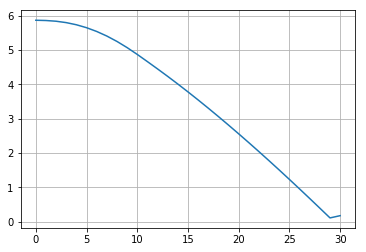

In [20]:
er=er[1:]
plt.plot(er)
plt.grid()
plt.show()

---

In [21]:
from sklearn.metrics.pairwise import pairwise_distances

In [22]:
D = pairwise_distances(Vi) # матрица расстояний
R = np.argsort(D) # номера слов в порядке увеличения расстояния

In [25]:
vocab = { i:w for i,w in enumerate(words) } # нумеруем слов в словаре

nn = np.random.permutation(len(words))[:10] # выбираем случайно N слов

# для выбранных слов печатаем близкие по w2v
{ vocab[i] : [ vocab[j] for j in  R[i,1:3]  ] for i in nn }

{'да': ['значит', 'отлаженный'],
 'никогда': ['человек', 'мозгу'],
 'понимаю': ['помог', 'почему'],
 'почти': ['выбирай', 'тебя'],
 'значит': ['отлаженный', 'хорошо'],
 'порядка': ['сто', 'портала'],
 'самому': ['иногда', 'корректировать'],
 'его': ['может', 'затормозить'],
 'человека': ['молодого', 'надежда'],
 'поучительно': ['хороших', 'вам']}